In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler

import demoji

# Data Import

In [2]:
#df_train_raw = pd.read_excel('Project Corpora/train.xlsx')

In [3]:
df = pd.read_csv('output/train_with_translation.csv') # this is the result of translation of ddescriptions
df.head(5)

,index,description,host_about,unlisted,description_language,host_about_language,description_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"This is a shared mixed room in our hostel, wit..."
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,"My space is close to Parque Eduardo VII, Salda..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,Trafaria’s House is a cozy and familiar villa ...
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en,"Charming apartment in Chiado, Between the Farg..."
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,Beautiful apartment on the beach.<br /> 2 min....


# Preprocesssing

## Splitting data into Train and Validation

In [4]:
# Split the original train dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, 
                                    stratify=df['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train_df', train_df.shape)
print('Shapes of val_df', val_df.shape)

Shapes of train_df (9996, 7)
Shapes of val_df (2500, 7)


In [5]:
x_train = train_df["description_english"]
y_train = train_df['unlisted']

x_val = val_df["description_english"]
y_val = val_df['unlisted']

# Training BERT 

In [6]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the training data
train_encodings = tokenizer(list(x_train), truncation=True, padding=True)

# Tokenize the testing data
test_encodings = tokenizer(list(x_val), truncation=True, padding=True)

# Prepare the data for the model
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                              torch.tensor(train_encodings['attention_mask']),
                                              torch.tensor(y_train.values))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                             torch.tensor(test_encodings['attention_mask']),
                                             torch.tensor(y_val.values))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

for epoch in tqdm(range(5)):
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

 15%|██████                                  | 95/625 [16:43<1:31:37, 10.37s/it]


 31%|███████████▉                           | 192/625 [37:16<1:14:58, 10.39s/it]


 46%|██████████████████▉                      | 289/625 [54:06<58:21, 10.42s/it]


 62%|████████████████████████               | 386/625 [1:10:54<41:24, 10.40s/it]


 77%|██████████████████████████████▏        | 483/625 [1:27:43<24:40, 10.43s/it]


 93%|████████████████████████████████████▏  | 580/625 [1:44:32<07:47, 10.38s/it]


  8%|███▏                                    | 50/625 [08:40<1:39:39, 10.40s/it]


 24%|█████████▏                             | 147/625 [25:31<1:22:50, 10.40s/it]


 39%|███████████████▏                       | 244/625 [42:19<1:05:48, 10.36s/it]


 55%|██████████████████████▎                  | 341/625 [59:03<49:00, 10.35s/it]


 70%|███████████████████████████▎           | 438/625 [1:15:45<32:11, 10.33s/it]


 86%|█████████████████████████████████▍     | 535/625 [1:32:29<15:32, 10.36s/it]


  1%|▎                                        | 5/625 [00:51<1:46:31, 10.31s/it]


 16%|██████▎                                | 102/625 [17:33<1:30:16, 10.36s/it]


 32%|████████████▍                          | 199/625 [34:14<1:13:22, 10.33s/it]


 47%|███████████████████▍                     | 296/625 [50:56<56:37, 10.33s/it]


 63%|████████████████████████▌              | 393/625 [1:07:38<40:03, 10.36s/it]


 78%|██████████████████████████████▌        | 490/625 [1:24:21<23:10, 10.30s/it]


 94%|████████████████████████████████████▋  | 587/625 [1:41:03<06:32, 10.33s/it]


  9%|███▋                                    | 57/625 [09:49<1:37:30, 10.30s/it]


 25%|█████████▌                             | 154/625 [26:31<1:21:04, 10.33s/it]


 40%|███████████████▋                       | 251/625 [43:12<1:04:22, 10.33s/it]


 56%|██████████████████████▊                  | 348/625 [59:54<47:37, 10.32s/it]


 71%|███████████████████████████▊           | 445/625 [1:16:35<30:55, 10.31s/it]


 87%|█████████████████████████████████▊     | 542/625 [1:33:17<14:16, 10.32s/it]


  2%|▊                                       | 12/625 [02:04<1:45:40, 10.34s/it]


 17%|██████▊                                | 109/625 [18:46<1:28:39, 10.31s/it]


 33%|████████████▊                          | 206/625 [35:32<1:13:34, 10.54s/it]


 48%|███████████████████▉                     | 303/625 [52:23<55:45, 10.39s/it]


 64%|████████████████████████▉              | 400/625 [1:09:26<39:07, 10.43s/it]


 80%|███████████████████████████████        | 497/625 [1:26:12<22:04, 10.35s/it]


 95%|█████████████████████████████████████  | 594/625 [1:43:07<05:23, 10.45s/it]


100%|█████████████████████████████████████████| 5/5 [9:03:49<00:00, 6525.85s/it]


In [10]:
# Evaluate the model
model.eval()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, dim=1)
        predictions.extend(predicted_labels.cpu().numpy().tolist())

100%|█████████████████████████████████████████| 157/157 [06:51<00:00,  2.62s/it]


In [11]:
accuracy = accuracy_score(y_val.values, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7236


### Saving the trained BERT model

In [12]:
# Specify the directory where you want to save the model
output_dir = 'output/bert1/'

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('output/bert1/tokenizer_config.json',
 'output/bert1/special_tokens_map.json',
 'output/bert1/vocab.txt',
 'output/bert1/added_tokens.json')

In [ ]:
# To load the saved model later, use the from_pretrained method of the model and tokenizer classes:

# model = BertForSequenceClassification.from_pretrained(output_dir)
# tokenizer = BertTokenizer.from_pretrained(output_dir)

In [14]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

              precision    recall  f1-score   support

      listed       0.76      0.84      0.80      1640
    unlisted       0.62      0.50      0.56       860

    accuracy                           0.72      2500
   macro avg       0.69      0.67      0.68      2500
weighted avg       0.71      0.72      0.72      2500



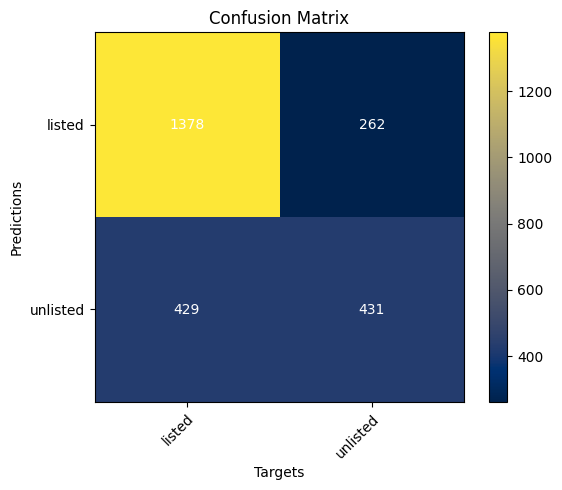

In [15]:
labels = {"listed":0, "unlisted":1}
print(classification_report(predictions, y_val.values, target_names = labels.keys()))

plot_cm(confusion_matrix(predictions, y_val.values), labels.keys())

### Push trained model to the Hugging Face Model Hub

In [17]:
# Having the authentication token stored in the cache folder
from huggingface_hub import notebook_login

notebook_login()

In [19]:
model2 = BertForSequenceClassification.from_pretrained(output_dir)

# Push the model to the Hugging Face Model Hub
model2.push_to_hub('bert_on_airbnb', organization='iryska')

/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/utils/hub.py:652: UserWarning: The `organization` argument is deprecated and will be removed in v5 of Transformers. Set your organization directly in the `repo_id` passed instead (`repo_id={organization}/{model_id}`).
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/iryska/bert_on_airbnb/commit/d6613251d8cd104c929d58590bf448b063e90dd9', commit_message='Upload BertForSequenceClassification', commit_description='', oid='d6613251d8cd104c929d58590bf448b063e90dd9', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# To load the model from the Hugging Face Model Hub, use the from_pretrained method with the repository name:

# model = BertForSequenceClassification.from_pretrained(f"{username}/{repo_name}")
# tokenizer = BertTokenizer.from_pretrained(f"{username}/{repo_name}")

              precision    recall  f1-score   support

      listed       0.91      0.79      0.85      2073
    unlisted       0.38      0.62      0.47       427

    accuracy                           0.76      2500
   macro avg       0.65      0.71      0.66      2500
weighted avg       0.82      0.76      0.78      2500



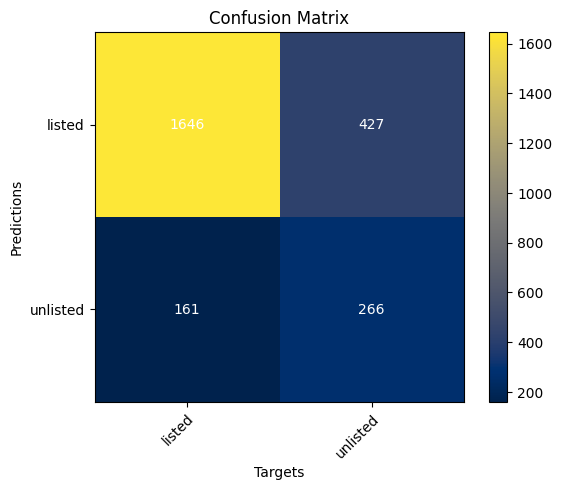

In [19]:
labels = {"listed":0, "unlisted":1}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred, y_val), labels.keys())